In [1]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *
from rsna_retro.seutao import *

Loading imports


In [2]:
torch.cuda.set_device(4)

In [3]:
# dbunch = get_seutao_dbunch(Meta.df_comb1, np_file, csv_file, bs=64)
dbunch = get_seutao_dbunch_meta(Meta.df_comb1, np_file, csv_file, bs=64)

loading features
Done loading features


## Load

In [4]:

class SequenceModel(nn.Module):
    def __init__(self, model_num):
        super(SequenceModel, self).__init__()

        # seq model 1
        self.fea_conv = nn.Sequential(nn.Dropout2d(drop_out),
                                      nn.Conv2d(feature_dim, 512, kernel_size=(1, 1), stride=(1,1),padding=(0,0), bias=False),
                                      nn.BatchNorm2d(512),
                                      nn.ReLU(),
                                      nn.Dropout2d(drop_out),
                                      nn.Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(),
                                      nn.Dropout2d(drop_out),
                                      )

        self.fea_first_final = nn.Sequential(nn.Conv2d(128*feature_num, 6, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=True))

        # # bidirectional GRU
        self.hidden_fea = hidden
        self.fea_lstm = nn.GRU(128*feature_num, self.hidden_fea, num_layers=lstm_layers, batch_first=True, bidirectional=True)
        self.fea_lstm_final = nn.Sequential(nn.Conv2d(1, 6, kernel_size=(1, self.hidden_fea*2), stride=(1, 1), padding=(0, 0), dilation=1, bias=True))

        ratio = 4
        if Add_position:
            model_num += 2
        else:
            model_num += 1

        # seq model 2
        self.conv_first = nn.Sequential(nn.Conv2d(model_num, 128*ratio, kernel_size=(5, 1), stride=(1,1),padding=(2,0),dilation=1, bias=False),
                                        nn.BatchNorm2d(128*ratio),
                                        nn.ReLU(),
                                        nn.Conv2d(128*ratio, 64*ratio, kernel_size=(3, 1), stride=(1, 1), padding=(2, 0),dilation=2, bias=False),
                                        nn.BatchNorm2d(64*ratio),
                                        nn.ReLU())

        self.conv_res = nn.Sequential(nn.Conv2d(64 * ratio, 64 * ratio, kernel_size=(3, 1), stride=(1, 1),padding=(4, 0),dilation=4, bias=False),
                                      nn.BatchNorm2d(64 * ratio),
                                      nn.ReLU(),
                                      nn.Conv2d(64 * ratio, 64 * ratio, kernel_size=(3, 1), stride=(1, 1),padding=(2, 0),dilation=2, bias=False),
                                      nn.BatchNorm2d(64 * ratio),
                                      nn.ReLU(),)

        self.conv_final = nn.Sequential(nn.Conv2d(64*ratio, 1, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), dilation=1,bias=False))

        # bidirectional GRU
        self.hidden = hidden
        self.lstm = nn.GRU(64*ratio*6, self.hidden, num_layers=lstm_layers, batch_first=True, bidirectional=True)
        self.final = nn.Sequential(nn.Conv2d(1, 6, kernel_size=(1, self.hidden*2), stride=(1, 1), padding=(0, 0), dilation=1, bias=True))


    def forward(self, fea, x):
        batch_size, _, _, _ = x.shape

        fea = self.fea_conv(fea)
        fea = fea.permute(0, 1, 3, 2).contiguous()
        fea = fea.view(batch_size, 128 * feature_num, -1).contiguous()
        fea = fea.view(batch_size, 128 * feature_num, -1, 1).contiguous()
        fea_first_final = self.fea_first_final(fea)
        #################################################
        out0 = fea_first_final.permute(0, 3, 2, 1)
        #################################################

        # bidirectional GRU
        fea = fea.view(batch_size, 128 * feature_num, -1).contiguous()
        fea = fea.permute(0, 2, 1).contiguous()
        fea, _ = self.fea_lstm(fea)
        fea = fea.view(batch_size, 1, -1, self.hidden_fea * 2)
        fea_lstm_final = self.fea_lstm_final(fea)
        fea_lstm_final = fea_lstm_final.permute(0, 3, 2, 1)
        #################################################
        out0 += fea_lstm_final
        #################################################

        out0_sigmoid = torch.sigmoid(out0)
        x = torch.cat([x, out0_sigmoid], dim = 1)
        x = self.conv_first(x)
        x = self.conv_res(x)
        x_cnn = self.conv_final(x)
        #################################################
        out = x_cnn
        #################################################

        # bidirectional GRU
        x = x.view(batch_size, 256, -1, 6)
        x = x.permute(0,2,1,3).contiguous()
        x = x.view(batch_size, x.size()[1], -1).contiguous()
        x, _= self.lstm(x)
        x = x.view(batch_size, 1, -1, self.hidden*2)
        x = self.final(x)
        x = x.permute(0,3,2,1)
        #################################################
        out += x
        #################################################
        #res
        return out, out0

In [5]:
fold_index = -1
fold_num = 10
Add_position = True
lstm_layers = 2
seq_len = 24
hidden = 96
drop_out = 0.5
train_epoch = 40
feature_dim = 2048

In [6]:
feature_num = 1

In [7]:
m = SequenceModel(model_num=3).cuda().half()

In [8]:
xb,yb = dbunch.one_batch()

In [9]:
[x.shape for x in xb]

[torch.Size([64, 52, 2048]), torch.Size([64, 52, 6]), torch.Size([64, 52, 1])]

In [10]:
m(xb[0], xb[1]).shape

ValueError: not enough values to unpack (expected 4, got 3)

In [15]:
learn = get_learner(dbunch, m)

In [16]:
learn.add_cb(DePadLoss())

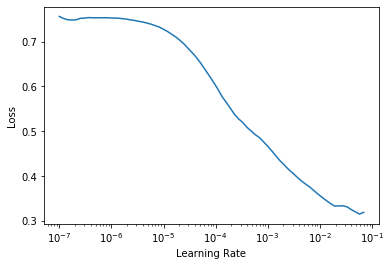

In [17]:
learn.lr_find()

## Train

In [17]:
do_fit(learn, 10, 1e-2)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.067697,0.066668,0.977359,0.960121,00:39
1,0.067060,0.067645,0.977448,0.959280,00:40
2,0.061940,0.068946,0.977333,0.958546,00:40
3,0.063408,0.065036,0.978328,0.960287,00:39
4,0.060798,0.066310,0.978203,0.959434,00:40
5,0.059672,0.063933,0.978336,0.960121,00:40
6,0.058195,0.061734,0.978920,0.961707,00:40
7,0.057011,0.061622,0.979141,0.961980,00:40
8,0.053673,0.060949,0.979257,0.962240,00:40
9,0.052732,0.060633,0.979370,0.962536,00:40


NameError: name 'name' is not defined